In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Read the data

In [2]:
players_df = pd.read_csv("../data/players.csv")
sessions_df = pd.read_csv("../data/sessions.csv")
tournaments_df = pd.read_csv("../data/tournaments.csv")
transactions_df = pd.read_csv("../data/transactions.csv")

In [3]:
display(players_df.head())
players_df.shape

,player_id,country,signup_date,acquisition_channel
0,1,CA,2024-11-09 02:55:26,Facebook
1,2,ZA,2025-01-10 10:19:12,Organic
2,3,CA,2024-12-30 13:35:03,Google
3,4,GB,2024-12-10 22:30:37,Referral
4,5,FR,2024-12-10 09:42:18,Facebook


(20000, 4)

In [4]:
display(sessions_df.head())
sessions_df.shape

,session_id,player_id,start_ts,end_ts,device
0,1,1,2025-02-19 19:16:26,2025-02-19 20:12:26,Android
1,2,1,2025-02-08 20:27:26,2025-02-08 20:56:26,Android
2,3,2,2025-01-12 12:47:12,2025-01-12 13:22:12,iOS
3,4,2,2025-04-10 10:33:12,2025-04-10 11:01:12,iOS
4,5,2,2025-04-15 22:52:12,2025-04-15 23:23:12,Android


(100206, 5)

In [5]:
display(tournaments_df.head())
tournaments_df.shape

,tourney_id,start_ts,entry_fee,prize_pool,avggrade_min,avggrade_max
0,1,2025-02-03 13:20:17,1,32,14,32
1,2,2025-03-12 02:50:52,5,200,48,56
2,3,2025-02-11 13:41:07,2,132,36,53
3,4,2024-12-16 06:03:55,1,84,7,21
4,5,2025-02-16 18:09:41,10,260,32,47


(500, 6)

In [6]:
display(transactions_df.head())
transactions_df.shape

,txn_id,player_id,txn_ts,txn_type,amount
0,1,1,2025-03-28 11:31:26,reward,34.59
1,2,1,2024-12-26 17:50:26,entry_fee,10.00
2,3,1,2024-12-21 02:28:26,deposit,90.73
3,4,1,2025-02-24 10:08:26,entry_fee,5.00
4,5,1,2025-01-13 19:05:26,entry_fee,20.00


(49887, 5)

In [7]:
# Convert date columns to datetime
players_df['signup_date'] = pd.to_datetime(players_df['signup_date'])

sessions_df['start_ts'] = pd.to_datetime(sessions_df['start_ts'])
sessions_df['end_ts'] = pd.to_datetime(sessions_df['end_ts'])

tournaments_df['start_ts'] = pd.to_datetime(tournaments_df['start_ts'])

transactions_df['txn_ts'] = pd.to_datetime(transactions_df['txn_ts'])


# Part A

## 1 KPIs notebook or sheet showing:

### Day 1 retention

In [8]:
# Merge sessions with players to get signup_date for each session
merged_df = sessions_df.merge(players_df, on='player_id')

# Calculate session day relative to signup
merged_df['session_day'] = (merged_df['start_ts'].dt.date - merged_df['signup_date'].dt.date).dt.days

# Filter for Day 1 sessions
day1_sessions = merged_df[merged_df['session_day'] == 1]

# Unique players who returned on Day 1
day1_players = day1_sessions['player_id'].nunique()

# Total new players (Day 0 installs)
total_players = players_df['player_id'].nunique()

# Day-1 retention rate
day1_retention = (day1_players / total_players) * 100

print(f"Day-1 Retention: {day1_retention:.2f}%")

Day-1 Retention: 3.21%


#### 24 hours retention

In [ ]:
# Merge to associate sessions with signup time
merged_df = sessions_df.merge(players_df, on='player_id')

# Filter sessions that occurred after signup
merged_df = merged_df[merged_df['start_ts'] > merged_df['signup_date']]

# Filter sessions that occurred within 24 hours after signup
merged_df['hours_since_signup'] = (merged_df['start_ts'] - merged_df['signup_date']).dt.total_seconds() / 3600
day1_sessions = merged_df[merged_df['hours_since_signup'] <= 24]

# Unique players who returned within 24 hours
day1_players = day1_sessions['player_id'].nunique()

# Total number of new players
total_players = players_df['player_id'].nunique()

# Day-1 (24hr) retention rate
day1_retention = (day1_players / total_players) * 100

print(f"Day-1 (24hr) Retention: {day1_retention:.2f}%")

### 7-day cumulative ARPU (USD)

In [12]:
valid_txns['txn_type'].unique()

array(['entry_fee', 'withdrawal', 'deposit', 'reward'], dtype=object)

In [17]:
valid_txns[valid_txns['txn_type'] == 'deposit']['amount']

133      76.53
208      45.42
363      76.16
386      45.18
399      58.17
         ...  
49709    14.17
49729    94.81
49794    91.36
49824    90.93
49877    72.76
Name: amount, Length: 896, dtype: float64

In [18]:
# Merge transactions with signup dates
merged_df = transactions_df.merge(players_df, on='player_id')

# Filter transactions within 7 days (i.e., first 7*24 = 168 hours after signup)
merged_df['hours_since_signup'] = (merged_df['txn_ts'] - merged_df['signup_date']).dt.total_seconds() / 3600
valid_txns = merged_df[merged_df['hours_since_signup'] <= 168]

# Total revenue from those transactions (assumes 'amount' is in USD)
total_deposits = valid_txns[valid_txns['txn_type'] == 'deposit']['amount'].sum()
total_withdrawal = valid_txns[valid_txns['txn_type'] == 'withdrawal']['amount'].sum()
total_revenue = total_deposits - total_withdrawal

# Total number of new users
total_users = players_df['player_id'].nunique()

# 7-day cumulative ARPU
arpu_7_day = total_revenue / total_users

print(f"7-Day Cumulative ARPU: ${arpu_7_day:.2f}")

7-Day Cumulative ARPU: $1.86


### 30-day churn rate (%)

In [19]:
# Merge sessions with signup dates
merged_df = sessions_df.merge(players_df, on='player_id')

# Calculate time since signup
merged_df['days_since_signup'] = (merged_df['start_ts'] - merged_df['signup_date']).dt.days

# Filter sessions within 30 days after signup (excluding Day 0)
active_within_30d = merged_df[(merged_df['days_since_signup'] > 0) & (merged_df['days_since_signup'] <= 30)]

# Players who had at least one session within 30 days
retained_players = active_within_30d['player_id'].unique()

# All new players
all_players = players_df['player_id'].unique()

# Players who churned = those not in retained_players
churned_players = set(all_players) - set(retained_players)

# 30-day churn rate
churn_rate_30d = (len(churned_players) / len(all_players)) * 100

print(f"30-Day Churn Rate: {churn_rate_30d:.2f}%")

30-Day Churn Rate: 41.37%


## 2. Insight memo:

### What is the biggest monetisation opportunity for Q3?

In [22]:
print(transactions_df['txn_ts'].min())
print(transactions_df['txn_ts'].max())

2024-11-01 20:42:13
2025-06-29 18:37:43


In [23]:
# Filter + copy to avoid SettingWithCopyWarning
deposits_2025 = transactions_df[
    (transactions_df['txn_ts'].dt.year == 2025) &
    (transactions_df['txn_type'] == 'deposit')
].copy()

# Now it's safe to add a column
deposits_2025['quarter'] = deposits_2025['txn_ts'].dt.quarter

# Group and sum
q_deposit_summary = deposits_2025.groupby('quarter')['amount'].sum().reset_index()
print(q_deposit_summary)

   quarter     amount
0        1  592340.77
1        2  313404.28


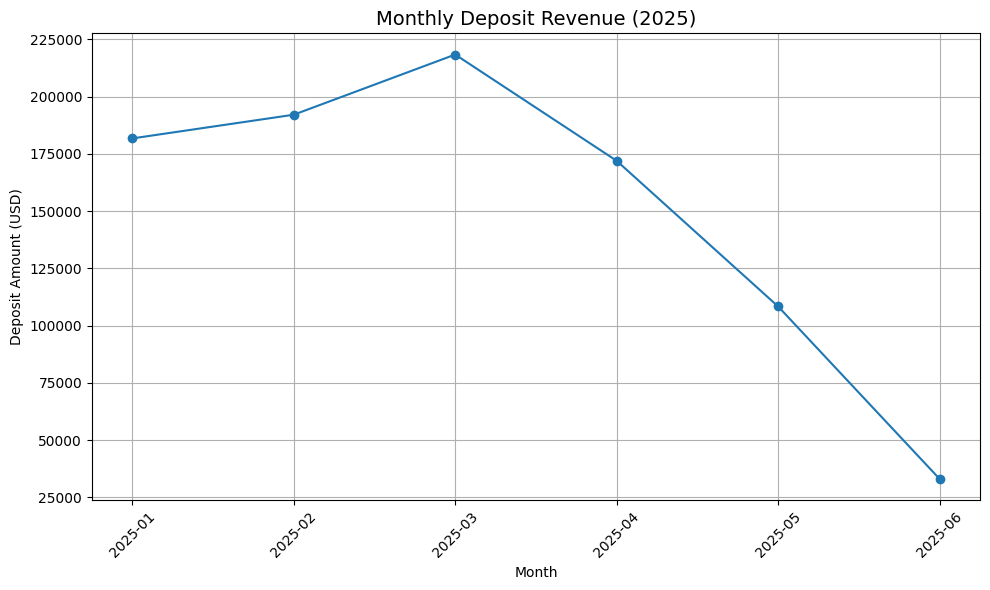

In [24]:
# Filter for deposits only in 2025
deposits_2025 = transactions_df[
    (transactions_df['txn_ts'].dt.year == 2025) &
    (transactions_df['txn_type'] == 'deposit')
].copy()

# Group by month and sum amounts
deposits_2025['month'] = deposits_2025['txn_ts'].dt.to_period('M')
monthly_revenue = deposits_2025.groupby('month')['amount'].sum().reset_index()
monthly_revenue['month'] = monthly_revenue['month'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue['month'], monthly_revenue['amount'], marker='o')
plt.title("Monthly Deposit Revenue (2025)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Deposit Amount (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
# Add quarter
sessions_df['quarter'] = sessions_df['start_ts'].dt.quarter
sessions_df['year'] = sessions_df['start_ts'].dt.year

# Filter 2025 only
sessions_2025 = sessions_df[sessions_df['year'] == 2025]

In [ ]:
engagement_summary = sessions_2025.groupby('quarter').agg(
    unique_players=('player_id', 'nunique'),
    total_sessions=('session_id', 'count')
).reset_index()

# Add sessions per player
engagement_summary['sessions_per_player'] = (
    engagement_summary['total_sessions'] / engagement_summary['unique_players']
)

print(engagement_summary)

In [ ]:
# Players active in Q1 and Q2
q1_players = set(sessions_2025[sessions_2025['quarter'] == 1]['player_id'])
q2_players = set(sessions_2025[sessions_2025['quarter'] == 2]['player_id'])

# Churned: in Q1 but not in Q2
churned_players = q1_players - q2_players

print("Churned players count:", len(churned_players))

In [ ]:
# Get Q1 deposits
q1_deposits = transactions_df[
    (transactions_df['txn_ts'].dt.year == 2025) &
    (transactions_df['txn_ts'].dt.quarter == 1) &
    (transactions_df['txn_type'] == 'deposit') &
    (transactions_df['player_id'].isin(churned_players))
]

print(f"Total Q1 deposits from churned players: {q1_deposits['amount'].sum():.2f}$")

### Which cohort needs extra retention effort and why?

In [ ]:
players_df['signup_month'] = players_df['signup_date'].dt.to_period('M')

In [ ]:
# Get Q2 active player IDs
q2_active_players = set(
    sessions_df[
        (pd.to_datetime(sessions_df['start_ts']).dt.year == 2025) &
        (pd.to_datetime(sessions_df['start_ts']).dt.quarter == 2)
    ]['player_id']
)

# Add retention flag
players_df['retained_in_q2'] = players_df['player_id'].isin(q2_active_players)

In [ ]:
cohort_retention = players_df.groupby('signup_month')['retained_in_q2'].mean().reset_index()
cohort_retention.columns = ['signup_month', 'q2_retention_rate']
print(cohort_retention.sort_values('q2_retention_rate'))

In [ ]:
# Join sessions with players
merged_df = sessions_df.merge(players_df[['player_id', 'signup_date']], on='player_id')

# Keep only sessions within 30 days of signup
merged_df['days_since_signup'] = (merged_df['start_ts'] - merged_df['signup_date']).dt.days
month1_sessions = merged_df[merged_df['days_since_signup'].between(0, 30)]

# Flag retained players
retained_players = month1_sessions['player_id'].unique()
players_df['month1_retained'] = players_df['player_id'].isin(retained_players)

# Add signup month
players_df['signup_month'] = players_df['signup_date'].dt.to_period('M')

# Calculate Month-1 retention rate per cohort
cohort_retention_30d = players_df.groupby('signup_month')['month1_retained'].mean().reset_index()
cohort_retention_30d.columns = ['signup_month', 'month1_retention_rate']
print(cohort_retention_30d.sort_values('month1_retention_rate'))

In [ ]:
# Join transactions to players
merged_txn = transactions_df.merge(players_df[['player_id', 'signup_month']], on='player_id')

# Filter for deposits
deposits = merged_txn[merged_txn['txn_type'] == 'deposit']

# Sum deposits per cohort
cohort_revenue = deposits.groupby('signup_month')['amount'].sum().reset_index()
cohort_revenue.columns = ['signup_month', 'total_deposits']
print(cohort_revenue.sort_values('total_deposits'))